# OLD VERSION OF ADAPTIVE STEP SIZE (dt+=g dt instead of dt+=dt)

## Work on different SDE and look at order of convergence

In this section, we present different toy model and have a look at how the adaptive method perform compared to non adaptive.

The first model is: 
$$
U(x) = 0.1 x^2 + \cos(x)^2\\
U'(x) = 0.2x -2 \sin(x) \cos(x)
$$
so the SDE of interest is : 
$$
dx = -U'(x) dt + \sqrt{2 \tau dt} dW \\
$$

and the transformed one is: 
$$
dy = -U'(y) g(y) dy +\tau g'(y) dt+ \sqrt{2 \tau dt g(y)} dW \\
$$


In [2]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Code for SDE (non adaptive)

In [3]:
########################
# Potential parameters #
########################
from numba import jit,njit,vectorize, float64, int32

def getU(x):
    """
    potential of -the infinite double well
    """

    return 0.1*x*x+np.cos(x)*np.cos(x)
    
# define the gradV function 
@njit(float64(float64))
def getminusdU(x):
    """
    Compute the potential of the infinite double well:
    x: float 
    """

    return 0.2*x-2*np.sin(x)*np.cos(x)


@njit(float64(float64,float64,float64,float64))
def e_m_method(y0,s,b1,dt):
    """
    The Euler-Maruyama scheme applied to the overdamped langevin with infinite double well:
    Input
    -----
    y0: float
        value of y at t_n
    s: float
        value of additive noise constant
    b1: float
        brownian increment 
    dt: float
        time increment

    Output
    ------
    y1: float 
        value of y at time t+h

    """
    y1=y0 - getminusdU(y0)*dt+s*b1
    return y1    


@njit(float64(float64,float64,float64))
def run_num(Ntot,dt,s):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of steps to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    s: float 
        Is sqrt(2 \tau dt). 
    Return
    ------
    y0: float
        Value of X(T) as approximated by the numerical scheme chosen
        
    """
    y0 = np.random.normal(0,1) #set up 1 as initial conditions
    for jj in range(Ntot): # Run until T= Tsec
        b1 = np.random.normal(0,1)
        y1 = e_m_method(y0,s,b1,dt)
        y0=y1 
    return (y0)



@njit(parallel=True)
def nsample(n_samples,T,dt,tau): # Function is compiled and runs in machine code
    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)

    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    N = int(np.round(1/dt,6))  #size of the time steps
    Ntot = N*T #total number of steps to take to arrive at T in steps of dt 
    y_final = [] 
    s = np.sqrt(2*tau*dt)
    for i in range(n_samples):
        yf =run_num(Ntot,dt,s)
        y_final.append(yf)
    y_final=np.array(y_final)
    return y_final



In [4]:
## RUNNING TIME 3min !!
n_samples=100000
T=10
tau=1
dt=0.01
dtbounds = np.array([0.01,0.01])
## environ 60.5ms sec for those parameters
### Compile and run without the correction term G
####################-------######################
%time nsample(1,T,dt,tau)
%time y = nsample(n_samples,T,dt,tau)

CPU times: user 807 ms, sys: 0 ns, total: 807 ms
Wall time: 637 ms
CPU times: user 11.1 s, sys: 899 µs, total: 11.1 s
Wall time: 1.16 s


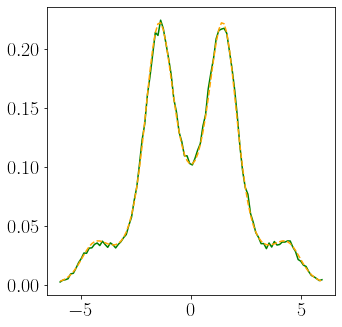

In [5]:
bound=6
fig, ((ax1))= plt.subplots(1,1,figsize=(5,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

### Plot without the correction term G
########-------#######################
histogram,bins = np.histogram(y,bins=100,range=[-bound,bound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.plot(midx,histogram,label="without G",color="green")
rho = np.exp(- (getU(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
ax1.plot(midx,rho,'--',label='Truth',color="orange")

### Code for tranfromed SDE

In [6]:
############ WRITE ON FASTER CODE FOR ADAPIVE METHOD ##############
from numba import jit,njit,vectorize, float64, int32, boolean

########################
# Potential parameters #
########################

def getU(x):
    """
    potential of -the infinite double well
    """

    return 0.1*x*x+np.cos(x)*np.cos(x)
    
# define the gradV function 
@njit(float64(float64))
def getminusdU(x):
    """
    Compute the potential of the infinite double well:
    x: float 
    """

    return 0.2*x-2*np.sin(x)*np.cos(x)

########################
#  Adaptive function G #
########################


@njit(float64[:](float64,float64,float64[:]))
def getg(x,h,dtbounds):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """
    dtmin=dtbounds[0]
    dtmax=dtbounds[1]

    M=h/dtmin
    m=h/dtmax

    x3=np.power(x,3)

    # value of function f, f' and f^2
    f=0.2*x-2*np.sin(x)*np.cos(x)
    fprime= 2*np.sin(x)*np.sin(x)-2*np.cos(x)*np.cos(x)+0.2
    f2 = f*f

    #compute the value of phi(f(x)) = \sqrt{f(x)^2}
    phif = np.sqrt(f2)
    phif2 = f2*f2

    # value of m^2
    m2 = m*m

    #compute gx
    gx_den=np.sqrt(phif2+m2)
    gx_num = gx_den/M + 1 
    gx=gx_num/gx_den

    #compute gx prime 
    gxp_num= -f*fprime
    gxp_den = gx_den*gx_den*gx_den
    gxprime= gxp_num/gxp_den

    #round number to avoid having too large number 
    gx = gx
    gxprime = gxprime

    #return
    re=np.array([gx,gxprime])
    return re

########################################### 
#  Numerical method with G prime included #
###########################################

@njit(float64[:](float64,float64,float64,float64,float64[:]))
def e_m_ada_withG(y0,tau,b1,dt,dtbounds):
    """
    The Euler-Maruyama scheme applied to the infinite double well
    y0: float
        value of y at t_n
    tau: float
        value of the temperature 
    b1: float
        brownian increment 
    dt: float
        time increment
    """
    re=getg(y0,dt,dtbounds)
    gy=re[0]
    nablag=re[1]
    newdt = np.round(gy*dt,7)
    y1=y0-getminusdU(y0)*newdt+tau*nablag*dt+np.sqrt(tau*dt*2)*b1*np.sqrt(gy)
    yt=np.array([y1,newdt])
    return yt    


# @njit(float64[:](float64,float64,float64,float64[:]))
@njit(nopython=True)
def run_untilT_withG(T,dt,tau,dtbounds):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of steps to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in sqrt(2 \tau dt). 
    Return
    ------
    yf: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    y0 = np.random.normal(0,1) #initial value
    t=0 #initialise time at t=0
    t_count=0.0 #count the number of steps in time required 
    while t<T:
        b1 = np.random.normal(0,1)
        yt = e_m_ada_withG(y0,tau,b1,dt,dtbounds)
        y1=yt[0]
        newdt=yt[1]
        y0=y1 
        t=np.round(t+newdt,7)
        t_count=t_count+1
    y_t = np.array([y0,t_count])
    return (y_t)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def nsample_ada(n_samples,T,dt,tau,dtbounds,metod): # Function is compiled and runs in machine code

    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """

    # yt_list=np.zeros((n_samples,2)) #vector to save solutions and number of run
    yt_list=[]

    for i in range(n_samples):
        yf_t =method(T,dt,tau,dtbounds)
        yt_list.append(yf_t[0])
        # yt_list[i,::]=yf_t
    yt_list= np.array(yt_list)
    return yt_list


/home/s2133976/.local/lib/python3.8/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [8]:
## RUNNING TIME 3min !!
n_samples=100000
T=10
tau=1
dt=0.01
dtbounds = np.array([0.01,0.01])
## environ 20 sec for those parameters
method=run_untilT_withG
### Compile and run without the correction term G
####################-------######################
%time nsample_ada(1,T,dt,tau,dtbounds,method)
%time y_nonada= nsample_ada(n_samples,T,dt,tau,dtbounds,method)


CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 16 ms
CPU times: user 3min 15s, sys: 207 ms, total: 3min 16s
Wall time: 19.2 s


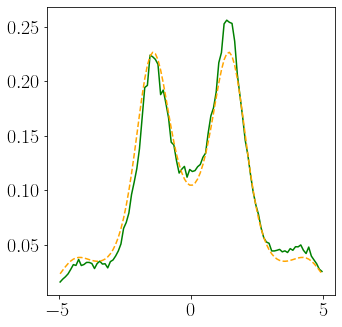

In [45]:
bound=5
fig, ((ax1))= plt.subplots(1,1,figsize=(5,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

### Plot without the correction term G
########-------#######################
histogram,bins = np.histogram(y_nonada,bins=100,range=[-bound,bound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax1.plot(midx,histogram,label="without G",color="green")
rho = np.exp(- (getU(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
ax1.plot(midx,rho,'--',label='Truth',color="orange")

A bias is introduced by the adaptive method... Something is not working here.


### Order of accuracy of non transformed SDE

In [27]:
# Compute the accuracte likelihood in the true solution
tau = 0.1
nbins=10
a=-10
b=10
Z1 = integrate.quad(lambda q: np.exp(-getU(q)/tau), -10,10)[0]
# Z_bin = integrate.quad(lambda q: np.exp(-getU(q)/tau), a,b)[0]/Z1

# Loop through the solution to obtain an order of accuracy
## Run for a large number of samples
nbins=70
T=10
nsamples=1000000
dt_list=[ np.round(2**(-j),5) for j in range(1,8,1)]
accuracy_list=[]
for j in dt_list:
    y= nsample(nsamples,T,j,tau)
    histogram,bins = np.histogram(y,bins=nbins,range=[-2,2], density=True)
    histogram = histogram/np.sum(histogram)
    error=0
    for i in range(0,len(bins)-1):
        a = bins[i]
        b = bins[i+1]
        Z_bin = integrate.quad(lambda q: np.exp(-getU(q)/tau), a,b)[0]/Z1
        error = error+np.abs(histogram[i]-Z_bin)
    accuracy_list.append(error)

In [28]:
logx1=np.log(dt_list[0])
logx2=np.log(dt_list[-1])
logy1=np.log(accuracy_list[0])
logy2=np.log(accuracy_list[-1])
a=(logy1-logy2)/(logx1-logx2)
b=logy1-a*logx1
print(a)
x=np.linspace(logx1,logx2,1000)
y_x=a*x+b
a_round=np.round(np.abs(a),2)

0.9002419643474521


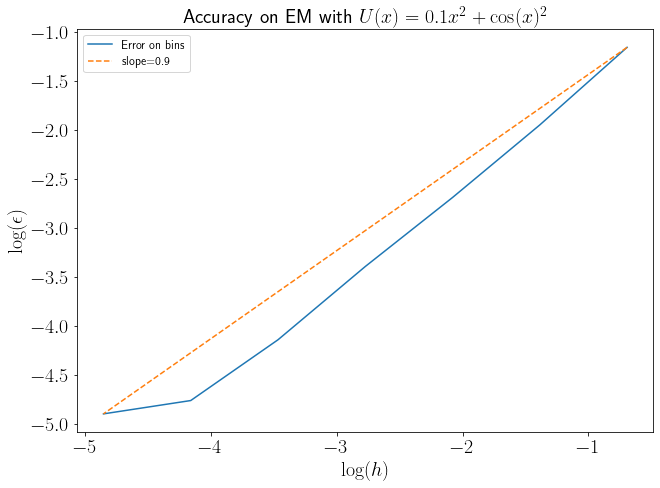

In [29]:
fig, (ax1)= plt.subplots(1,1,figsize=(10,7))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
ax1.plot(np.log(dt_list),np.log(accuracy_list),label="Error on bins")
ax1.plot(x,y_x,"--",label="slope="+str(a_round))
ax1.set_ylabel("$\log(\epsilon)$")
ax1.set_xlabel("$\log(h)$")
ax1.set_title("Accuracy on EM with $U(x)=0.1 x^2+\cos(x)^2$")
ax1.legend()